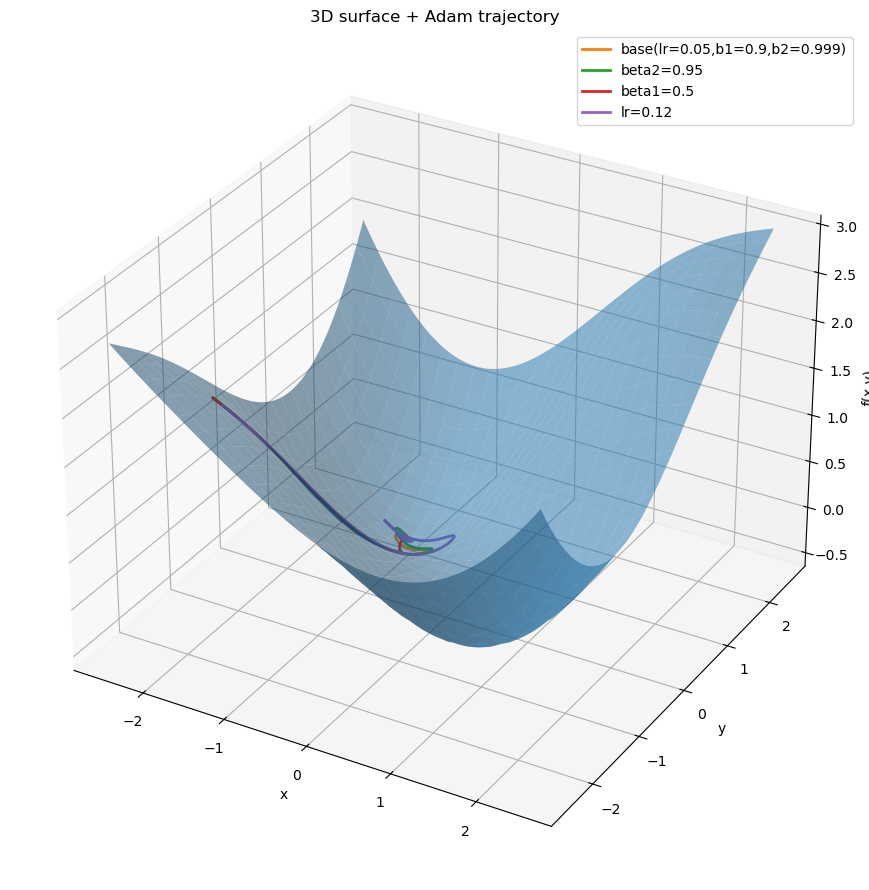

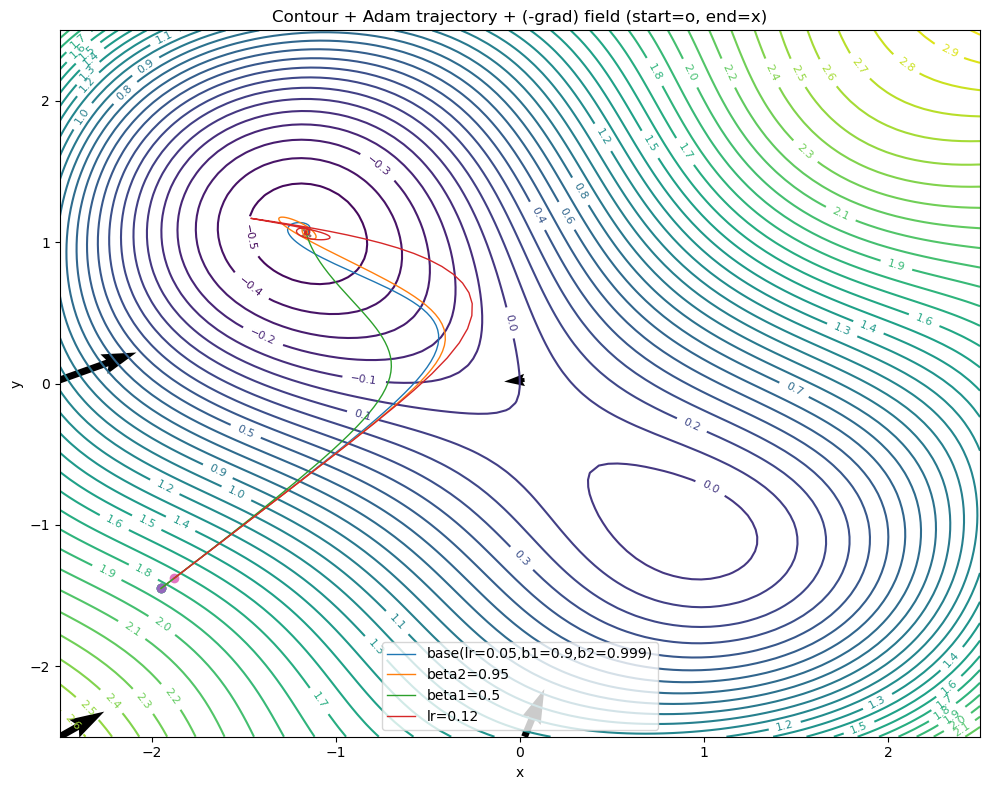

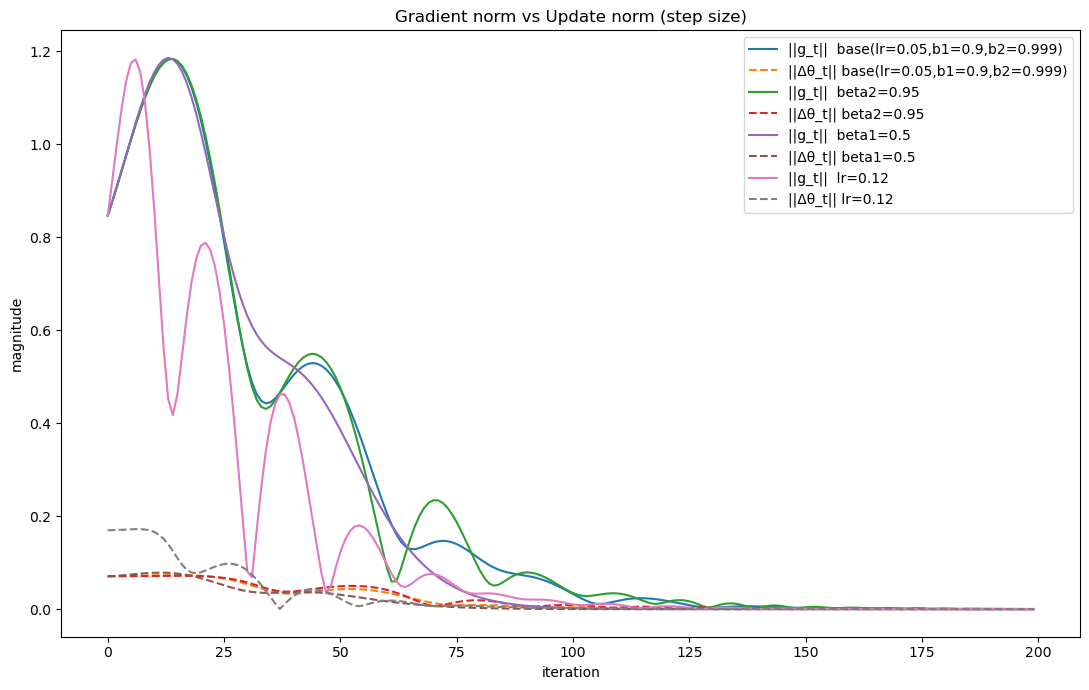

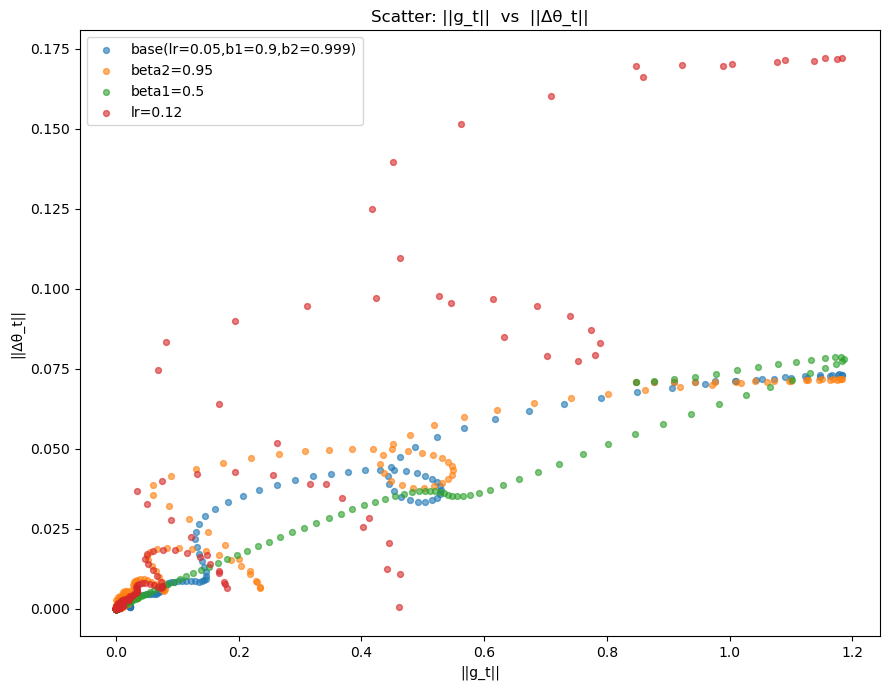

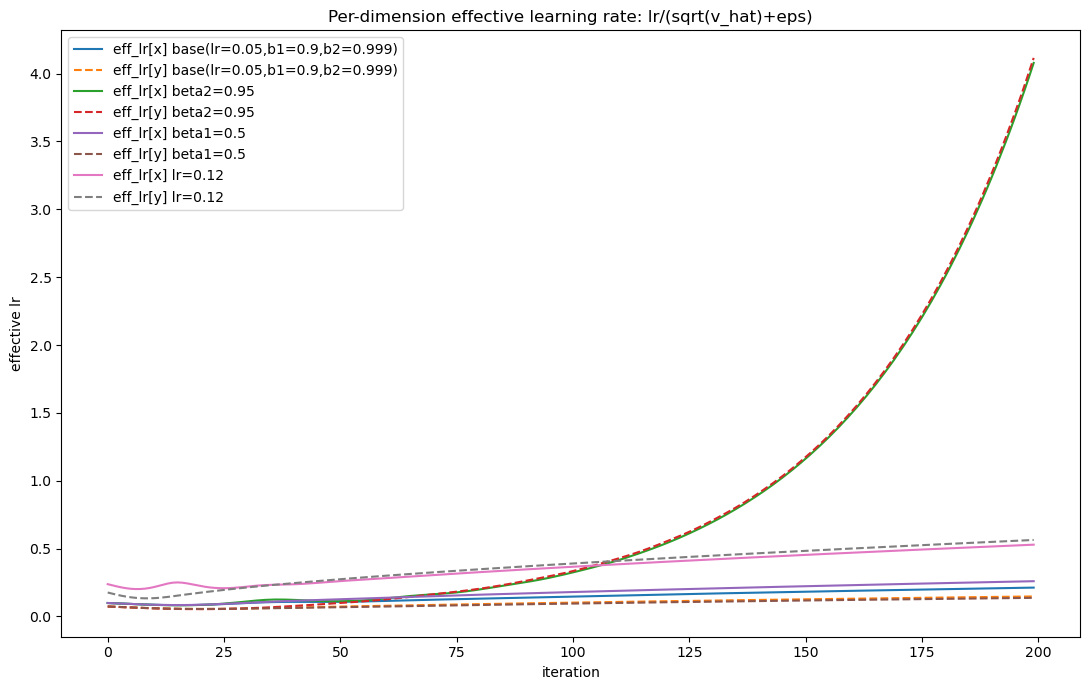

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# -----------------------------
# 1) 构造“起伏的三维地形” f(x, y)
#    2D 参数 (x,y) -> 1D 高度 z
# -----------------------------


def f_xy_jax(xy):
    x, y = xy[0], xy[1]
    return 0.2*(x**2 + y**2) + jnp.sin(x) * jnp.sin(y) + 0.3 * jnp.sin(x) * jnp.cos(0.2*y)

grad_f_xy_jax = jax.grad(f_xy_jax)

# 让你的 Adam 仍然用 numpy：这里做个桥接
def f_xy(xy: np.ndarray) -> float:
    return float(f_xy_jax(jnp.array(xy)))

def grad_f_xy(xy: np.ndarray) -> np.ndarray:
    g = grad_f_xy_jax(jnp.array(xy))
    return np.array(g, dtype=float)

# -----------------------------
# 2) 手写 Adam：显式记录 m, v, m_hat, v_hat, update
# -----------------------------
def adam_optimize(
    x0: np.ndarray,
    steps: int,
    lr: float = 0.05,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    maximize: bool = False,
):
    """
    minimize f by default; if maximize=True -> maximize f (i.e., minimize -f)
    Returns: history dict with arrays.
    """
    x = x0.astype(float).copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    xs = []
    fs = []
    gs = []
    ms = []
    vs = []
    updates = []
    eff_lrs = []  # per-dimension effective lr = lr / (sqrt(v_hat)+eps)

    for t in range(1, steps + 1):
        g = grad_f_xy(x)
        if maximize:
            g = -g  # maximize f <=> minimize -f

        # Adam moment updates
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)

        # Bias correction
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # Parameter-wise adaptive scaling
        denom = np.sqrt(v_hat) + eps
        update = lr * (m_hat / denom)

        x = x - update

        # record
        xs.append(x.copy())
        fs.append(f_xy(x) if not maximize else -f_xy(x))  # keep "optimized objective" consistent
        gs.append(g.copy())
        ms.append(m_hat.copy())
        vs.append(v_hat.copy())
        updates.append(update.copy())
        eff_lrs.append((lr / denom).copy())

    hist = {
        "x": np.array(xs),
        "f": np.array(fs),
        "g": np.array(gs),
        "m_hat": np.array(ms),
        "v_hat": np.array(vs),
        "update": np.array(updates),
        "eff_lr": np.array(eff_lrs),
    }
    return hist

# -----------------------------
# 3) 画图：3D曲面+路径、2D等高线+路径、步长-梯度关系
# -----------------------------
def plot_surface_and_paths(
    histories,
    labels,
    f_xy,
    grad_f_xy,
    xlim=(-2.5, 2.5),
    ylim=(-2.5, 2.5),
    grid_n=100,
    field_stride=50,      # 梯度场抽样步长（越大箭头越稀疏）
    path_stride=50,       # 轨迹上梯度箭头抽样步长
    show_field=True,      # 是否画全局负梯度场
    show_path_grad=False,  # 是否在轨迹上画负梯度箭头
):
    # ---------
    # 1) 用 f_xy 生成网格曲面 Z
    # ---------
    xs = np.linspace(*xlim, grid_n)
    ys = np.linspace(*ylim, grid_n)
    X, Y = np.meshgrid(xs, ys)

    Z = np.empty_like(X, dtype=float)
    for i in range(grid_n):
        for j in range(grid_n):
            Z[i, j] = float(f_xy(np.array([X[i, j], Y[i, j]], dtype=float)))

    # ---------
    # 2) 3D surface + trajectories（轨迹高度也用 f_xy）
    # ---------
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0, alpha=0.5)

    for hist, lab in zip(histories, labels):
        path = hist["x"]  # shape [T,2]
        zpath = np.array([float(f_xy(p)) for p in path], dtype=float)
        ax.plot(path[:, 0], path[:, 1], zpath, linewidth=2, label=lab)

    ax.set_title("3D surface + Adam trajectory")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    ax.legend()
    plt.tight_layout()

    # ---------
    # 3) 2D contour + trajectories
    #    并叠加负梯度场（下降方向）与轨迹梯度箭头
    # ---------
    plt.figure(figsize=(10, 8))
    cs = plt.contour(X, Y, Z, levels=40)
    plt.clabel(cs, inline=1, fontsize=8)

    # 3.1 全局负梯度场：用 grad_f_xy 计算
    if show_field:
        Xq = X[::field_stride, ::field_stride]
        Yq = Y[::field_stride, ::field_stride]
        U = np.zeros_like(Xq, dtype=float)  # x方向箭头（这里用 -grad）
        V = np.zeros_like(Yq, dtype=float)  # y方向箭头

        for i in range(Xq.shape[0]):
            for j in range(Xq.shape[1]):
                g = grad_f_xy(np.array([Xq[i, j], Yq[i, j]], dtype=float))
                U[i, j] = -float(g[0])
                V[i, j] = -float(g[1])

        plt.quiver(Xq, Yq, U, V, angles="xy", scale_units="xy")

    # 3.2 轨迹与轨迹上的负梯度箭头
    for hist, lab in zip(histories, labels):
        path = hist["x"]
        plt.plot(path[:, 0], path[:, 1], linewidth=1, label=lab)
        plt.scatter(path[0, 0], path[0, 1], marker="o")   # start
        plt.scatter(path[-1, 0], path[-1, 1], marker="x") # end

        if show_path_grad:
            pts = path[::path_stride]
            U2 = np.zeros(len(pts), dtype=float)
            V2 = np.zeros(len(pts), dtype=float)
            for k, p in enumerate(pts):
                g = grad_f_xy(np.array(p, dtype=float))
                U2[k] = -float(g[0])
                V2[k] = -float(g[1])
            plt.quiver(pts[:, 0], pts[:, 1], U2, V2, angles="xy", scale_units="xy")

    plt.title("Contour + Adam trajectory + (-grad) field (start=o, end=x)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
def plot_step_vs_grad(histories, labels):
    """
    展示：
    - ||g_t|| vs ||Δθ_t||（步长范数）
    - 每一维的 effective lr = lr/(sqrt(v_hat)+eps) 的变化
    """
    plt.figure(figsize=(11, 7))
    for hist, lab in zip(histories, labels):
        gnorm = np.linalg.norm(hist["g"], axis=1)
        unorm = np.linalg.norm(hist["update"], axis=1)
        plt.plot(gnorm, label=f"||g_t||  {lab}")
        plt.plot(unorm, linestyle="--", label=f"||Δθ_t|| {lab}")
    plt.title("Gradient norm vs Update norm (step size)")
    plt.xlabel("iteration")
    plt.ylabel("magnitude")
    plt.legend()
    plt.tight_layout()

    # scatter: ||g|| -> ||Δ||
    plt.figure(figsize=(9, 7))
    for hist, lab in zip(histories, labels):
        gnorm = np.linalg.norm(hist["g"], axis=1)
        unorm = np.linalg.norm(hist["update"], axis=1)
        plt.scatter(gnorm, unorm, s=18, alpha=0.6, label=lab)
    plt.title("Scatter: ||g_t||  vs  ||Δθ_t||")
    plt.xlabel("||g_t||")
    plt.ylabel("||Δθ_t||")
    plt.legend()
    plt.tight_layout()

    # effective lr over time (per-dimension)
    plt.figure(figsize=(11, 7))
    for hist, lab in zip(histories, labels):
        eff = hist["eff_lr"]  # shape [T,2]
        plt.plot(eff[:, 0], label=f"eff_lr[x] {lab}")
        plt.plot(eff[:, 1], linestyle="--", label=f"eff_lr[y] {lab}")
    plt.title("Per-dimension effective learning rate: lr/(sqrt(v_hat)+eps)")
    plt.xlabel("iteration")
    plt.ylabel("effective lr")
    plt.legend()
    plt.tight_layout()

# -----------------------------
# 4) 不同超参数对比实验
# -----------------------------
def main():
    np.random.seed(0)

    # 起点（你也可以换）
    x0 = np.array([-2.0, -1.5])

    steps = 200

    # Baseline
    h_base = adam_optimize(x0, steps, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8)

    # 对比1：beta2更小（v更“敏感”，更快跟踪梯度平方的变化）
    h_beta2_small = adam_optimize(x0, steps, lr=0.05, beta1=0.9, beta2=0.95, eps=1e-8)

    # 对比2：beta1更小（动量弱，m更“短记忆”）
    h_beta1_small = adam_optimize(x0, steps, lr=0.05, beta1=0.5, beta2=0.999, eps=1e-8)

    # 对比3：更大学习率（整体步长更大，但仍会被 v 抑制）
    h_lr_big = adam_optimize(x0, steps, lr=0.12, beta1=0.9, beta2=0.999, eps=1e-8)

    histories = [h_base, h_beta2_small, h_beta1_small, h_lr_big]
    labels = [
        "base(lr=0.05,b1=0.9,b2=0.999)",
        "beta2=0.95",
        "beta1=0.5",
        "lr=0.12",
    ]

    plot_surface_and_paths(histories, labels, f_xy,grad_f_xy)
    plot_step_vs_grad(histories, labels)

    plt.show()

if __name__ == "__main__":
    main()
